![Caribbeans for Climate](CFC_logo.PNG "image alt text")

<h1 style="text-align: center;">Caribbeans for Climate:</h>
<h1 style='text-align: center;'>Understanding extreme weather variability in the Caribbean region</h1>

---

## Overview
Extreme weather events, both atmospheric and oceanic, are increasing in frequency and intensity as a consequence of anthropogenic warming. The processes responsible for such events and their impacts on Caribbean lives remain to be well understood. Our Caribbeans for Climate community (a community of Caribbean-identified climate scientists, oceanographers, and practitioners) have created a cookbook analyzing Caribbean atmospheric and oceanic extreme weather variability from 1850-2015, using Coupled Model Intercomparison Project Phase 6 (CMIP6) data. In this notebook, we execute basic statistical analysis to investigate the linkages between extreme atmospheric and oceanic heat-related events and the possible causes behind them.


1. Locate times when sea surface temperatures exceeded the 90th percentile threshold 
1. Timeseries of ENSO 3.4 index
1. Locate times of hurricanes 
1. Run basic statistics to determine any correlation between the aforementioned metrics

## Prerequisites
Some relavent knowledge on how to use certain packages (e.g. `xarray`, `matplotlib`) would be helpful to you in understanding this tutorial. If you need a refresher on how to employ these packages please refer to the [Pythia Foundations](https://foundations.projectpythia.org/landing-page.html) page. Also, please refer to the Project Pythia's [CMIP6 cookbook](https://projectpythia.org/cmip6-cookbook/README.html) page to familiarize yourself on how to ingest CMIP6 data.


| Concepts | Importance | Notes |
| --- | --- | --- |
| [CMIP6 data structure](https://projectpythia.org/cmip6-cookbook/README.html) | Necessary | Familiarity with query techniques|
| [Xarray](https://foundations.projectpythia.org/core/xarray.html) | Necessary | Familiarity with manipulating data structure|
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Helpful|
| Project management | Helpful | |

- **Time to learn**: estimate in minutes. For a rough idea, use 5 mins per subsection, 10 if longer; add these up for a total. Safer to round up and overestimate.
- **System requirements**:
    - Populate with any system, version, or non-Python software requirements if necessary
    - Otherwise use the concepts table above and the Imports section below to describe required packages as necessary
    - If no extra requirements, remove the **System requirements** point altogether

---

## Pip install `regionmask` and `xmip` packages into current environment

In [2]:
!pip install git+https://github.com/mathause/regionmask.git

  Cloning https://github.com/mathause/regionmask.git to /tmp/pip-req-build-3rsczepr
  Running command git clone --filter=blob:none --quiet https://github.com/mathause/regionmask.git /tmp/pip-req-build-3rsczepr
  Resolved https://github.com/mathause/regionmask.git to commit 8fa448e1ae9131ecb028b52ce3740d3627d8fe75
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for regionmask: filename=regionmask-0.9.0.post1.dev95+g8fa448e-py3-none-any.whl size=68020 sha256=dcf075369b36cf21a64e24bb41c36df4271b17c928c36a9e4fb359b4505a7b74
  Stored in directory: /tmp/pip-ephem-wheel-cache-tlpiug1m/wheels/12/3c/e1/f1c2864aa8015b011d0c6dca10f004441dd966f8b80b6e0583
Successfully built regionmask


In [3]:
!pip install git+https://github.com/jbusecke/xmip.git

  Cloning https://github.com/jbusecke/xmip.git to /tmp/pip-req-build-239cab3i
  Running command git clone --filter=blob:none --quiet https://github.com/jbusecke/xmip.git /tmp/pip-req-build-239cab3i
  Resolved https://github.com/jbusecke/xmip.git to commit aff665950556abc1bdbae521c308a86f9ef8899a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached xgcm-0.6.1-py3-none-any.whl.metadata (6.0 kB)
Using cached xgcm-0.6.1-py3-none-any.whl (60 kB)
  Created wheel for xmip: filename=xmip-0.7.3.dev20+gaff6659-py3-none-any.whl size=58791 sha256=f7db69302dd7fa6266a521c05d6981a812925145107cac6500333c00c9616941
  Stored in directory: /tmp/pip-ephem-wheel-cache-s_k5w0gr/wheels/cc/cb/e0/c0e3e2261ea5177d2f86070a483c40d9c878e6dd2e14a7f824
Successfully built xmip
  Attempting uninstall: xgcm
    Found existing installation: xgcm 0.8.1
    Uninstalling xgcm-0.8.1:
      Successfully uninstalled xgcm-0.8.1
  A

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:43885")
client

<Client: 'tcp://127.0.0.1:43885' processes=8 threads=8, memory=29.67 GiB>

## Imports

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec
import nc_time_axis
import regionmask  
from xmip.preprocessing import combined_preprocessing
from xmip.regionmask import merged_mask
from xgcm import Grid
import xgcm 
from xgcm.autogenerate import generate_grid_ds
import cmocean as cm

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6

## Extreme SSTs

Marine heatwaves (MHWs) are characterized by extremely warm ocean temperatures that can span thousands of kilometers and last from days to months (Holbrook et al., 2019). Generally, they are defined as a MHW event when sea surface temperature (SST) exceed a certain threshold (typically, the 90th percentile threshold), and lasts for ≥5 consecutive days. These events can be devastating to marine life and the people that depend on maritime regions for sustenance and economy; such as fisheries and tribal communities. Despite their societal importance, however, a comprehensive understanding of the physical mechanisms driving MHWs in current and future climates does not yet exist. 

In this section, we will look at SST data from 2000-present and identify times when SST anomalies are within the 99th percentile and last for ≥10 days. These will be marked as extreme MHW events and help us better identify any potential correlative relationship between extreme SSTs and hurricane incidences. 

> Holbrook, Neil J., Hillary A. Scannell, Alexander Sen Gupta, Jessica A. Benthuysen, Ming Feng, Eric C. J. Oliver, Lisa V. Alexander, et al. “A Global Assessment of Marine Heatwaves and Their Drivers.” Nature Communications 10, no. 1 (June 14, 2019): 2624. https://doi.org/10.1038/s41467-019-10206-z.

A data request can be made with 3 keywords: 'experiment_id', 'table_id', and 'variable_id'.
`experiment_id = 'historical'`, `table_id='Oday'`, `variable_id=''`

List of potential variable names:
- `thetaoga = Global Average Sea Water Potential Temperature [degC]`
- `thetao = Sea Water Potential Temperature [degC]`
- `tosga = Global Average Sea Surface Temperature [degC]`
- `tos = Sea Surface Temperature [degC]`

### Load in the data

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [4]:
df_tos = df.query("table_id == 'Oday' & variable_id == 'tos' & experiment_id == 'historical'" + 
                  "& institution_id == 'NOAA-GFDL' & source_id == 'GFDL-CM4'")
df_tos

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9445,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Oday,tos,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
9446,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Oday,tos,gn,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701


In [5]:
np.unique(df_tos['zstore'])

array(['gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Oday/tos/gn/v20180701/',
       'gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Oday/tos/gr/v20180701/'],
      dtype=object)

In [6]:
# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_tos['zstore'].values[-1]
print(zstore)

# create a mutable-mapping-style interface to the store
mapper = fsspec.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds

gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Oday/tos/gn/v20180701/


<xarray.Dataset> Size: 375GB
Dimensions:    (bnds: 2, y: 1080, x: 1440, vertex: 4, time: 60225)
Coordinates:
  * bnds       (bnds) float64 16B 1.0 2.0
    lat        (y, x) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lat_bnds   (y, x, vertex) float32 25MB dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
    lon        (y, x) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lon_bnds   (y, x, vertex) float32 25MB dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
  * time       (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
    time_bnds  (time, bnds) object 964kB dask.array<chunksize=(30113, 1), meta=np.ndarray>
  * x          (x) float64 12kB -299.7 -299.5 -299.2 ... 59.53 59.78 60.03
  * y          (y) float64 9kB -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
Dimensions without coordinates: vertex
Data variables:
    tos        (time, y, x) float32 375GB dask.array<chunksize=(18, 1080, 1440), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36500.0
    comment:                <null ref>
    ...                     ...
    variable_id:            tos
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-11-16;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/e3b86300-29b2-4220-97ce-40fa504858e5...
    version_id:             v20180701

### Define the Caribbean Sea & Gulf of Mexico region

<GeoAxes: >

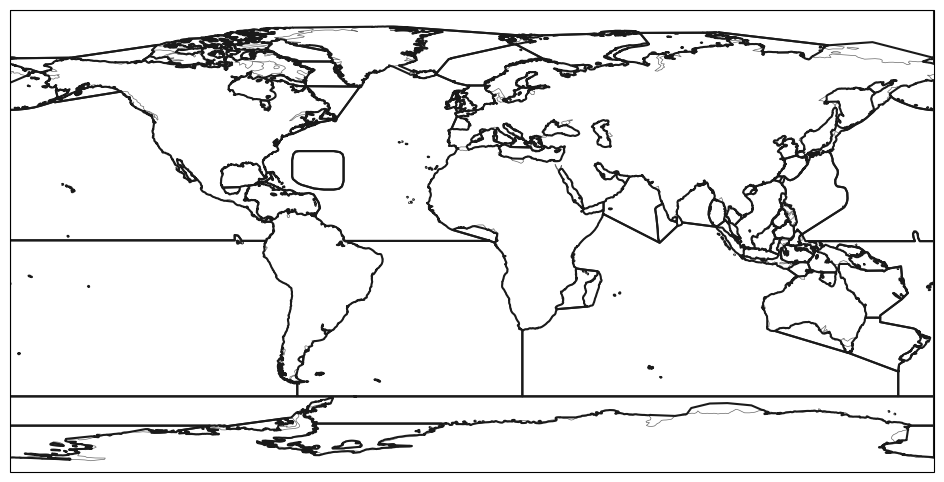

In [7]:
# load ocean basin data
basins = regionmask.defined_regions.natural_earth_v4_1_0.ocean_basins_50
basins.plot(add_ocean=False, add_label=False)

In [8]:
#da = ds.tos.isel(time=0).load()
mask = merged_mask(basins, ds[['lat', 'lon']])

/srv/conda/envs/notebook/lib/python3.11/site-packages/regionmask/core/mask.py:178: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(


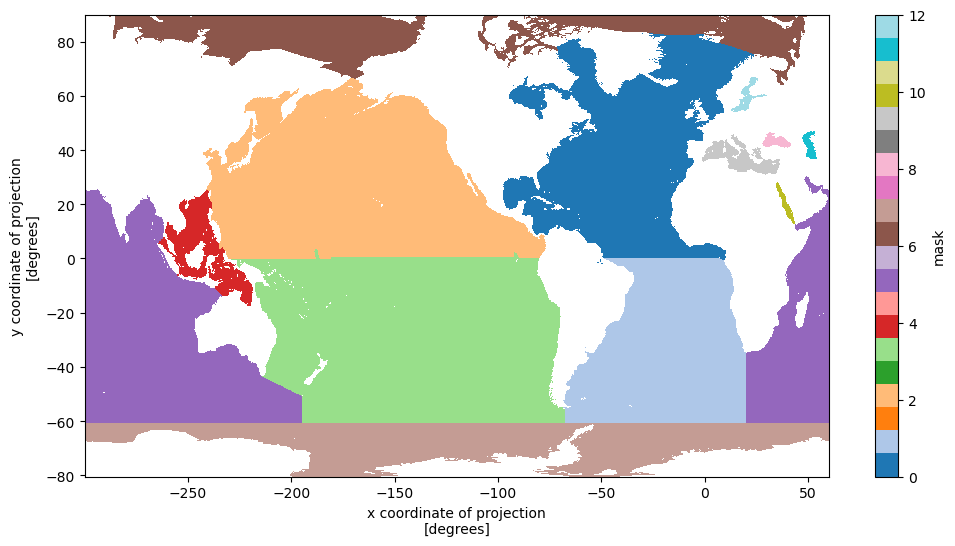

In [9]:
mask.plot(cmap='tab20')

In [9]:
natl = 0
sst = ds.tos.where(mask==natl)
carib = dict(x=slice(-98, -55), y=slice(8, 31), time=slice('1980', '2015'))
csst = sst.sel(**carib)

In [10]:
csst

<xarray.DataArray 'tos' (time: 12775, y: 98, x: 169)> Size: 846MB
dask.array<getitem, shape=(12775, 98, 169), dtype=float32, chunksize=(18, 98, 169), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 66kB dask.array<chunksize=(98, 169), meta=np.ndarray>
    lon      (y, x) float32 66kB dask.array<chunksize=(98, 169), meta=np.ndarray>
  * time     (time) object 102kB 1980-01-01 12:00:00 ... 2014-12-31 12:00:00
  * x        (x) float64 1kB -97.84 -97.58 -97.33 -97.08 ... -55.75 -55.5 -55.25
  * y        (y) float64 784B 8.222 8.469 8.716 8.963 ... 30.46 30.67 30.89
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    long_name:      Sea Surface Temperature
    original_name:  tos
    standard_name:  sea_surface_temperature
    units:          degC

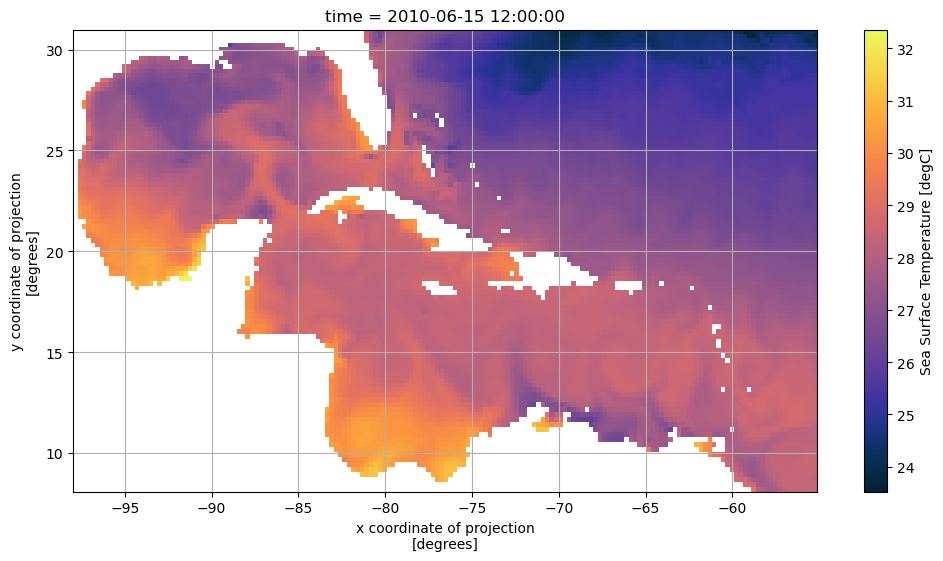

In [11]:
csst.sel(time='2010-06-15').squeeze().plot(cmap=cm.cm.thermal)
plt.grid();

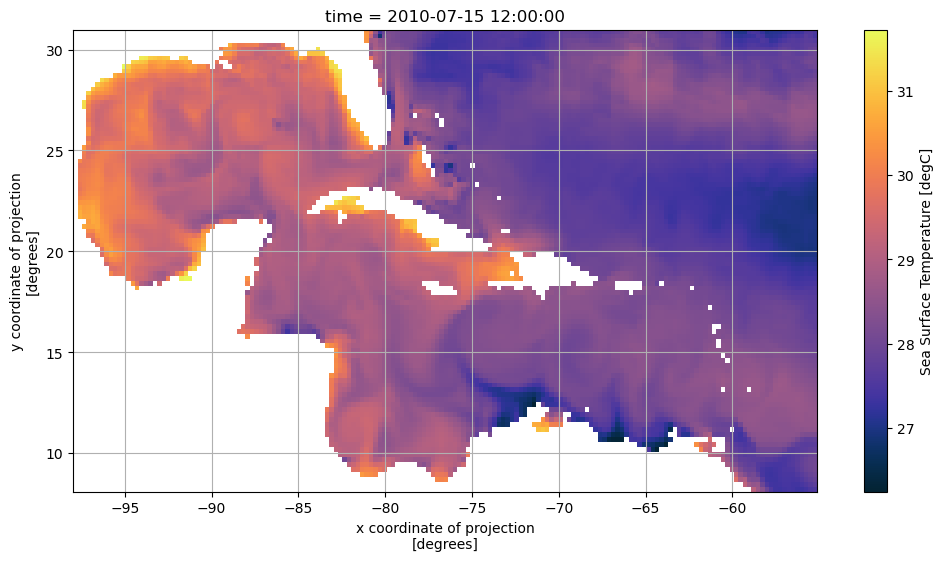

In [12]:
csst.sel(time='2010-07-15').squeeze().plot(cmap=cm.cm.thermal)
plt.grid();

In [11]:
csst.load()

<xarray.DataArray 'tos' (time: 12775, y: 98, x: 169)> Size: 846MB
array([[[      nan,       nan,       nan, ..., 25.8405  , 25.837206,
         25.840914],
        [      nan,       nan,       nan, ..., 25.810337, 25.781202,
         25.783344],
        [      nan,       nan,       nan, ..., 25.795334, 25.74435 ,
         25.726683],
        ...,
        [      nan,       nan,       nan, ..., 19.91767 , 19.753414,
         19.353695],
        [      nan,       nan,       nan, ..., 19.668154, 19.469423,
         19.149704],
        [      nan,       nan,       nan, ..., 19.434666, 19.236498,
         19.017475]],

       [[      nan,       nan,       nan, ..., 25.85912 , 25.85692 ,
         25.86652 ],
        [      nan,       nan,       nan, ..., 25.819614, 25.79908 ,
         25.821692],
        [      nan,       nan,       nan, ..., 25.78365 , 25.73449 ,
         25.756374],
...
        [      nan,       nan,       nan, ..., 21.318853, 21.47445 ,
         21.460293],
        [      nan,       nan,       nan, ..., 21.11503 , 21.28229 ,
         21.252943],
        [      nan,       nan,       nan, ..., 20.638948, 20.861607,
         20.986332]],

       [[      nan,       nan,       nan, ..., 26.682354, 26.65766 ,
         26.601227],
        [      nan,       nan,       nan, ..., 26.675678, 26.650387,
         26.605356],
        [      nan,       nan,       nan, ..., 26.662418, 26.64014 ,
         26.600674],
        ...,
        [      nan,       nan,       nan, ..., 21.230621, 21.442247,
         21.452328],
        [      nan,       nan,       nan, ..., 21.071938, 21.265345,
         21.223864],
        [      nan,       nan,       nan, ..., 20.654604, 20.853203,
         20.919558]]], dtype=float32)
Coordinates:
    lat      (y, x) float32 66kB 8.222 8.222 8.222 8.222 ... 30.89 30.89 30.89
    lon      (y, x) float32 66kB -97.88 -97.62 -97.38 ... -56.38 -56.12 -55.88
  * time     (time) object 102kB 1980-01-01 12:00:00 ... 2014-12-31 12:00:00
  * x        (x) float64 1kB -97.84 -97.58 -97.33 -97.08 ... -55.75 -55.5 -55.25
  * y        (y) float64 784B 8.222 8.469 8.716 8.963 ... 30.46 30.67 30.89
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    long_name:      Sea Surface Temperature
    original_name:  tos
    standard_name:  sea_surface_temperature
    units:          degC

When you want to use local Dask cluster in project pythia jupyterhub delete the protocol and IP address (`http://127.0.0.1:`) and replace with `/proxy/`

## Plot timeseries

In [18]:
from scipy.stats import linregress
lr = linregress(np.arange(0,12775), csst.mean(['x', 'y']).fillna(0.))
trend = (lr[0]*np.arange(0, 12775) + lr[1])

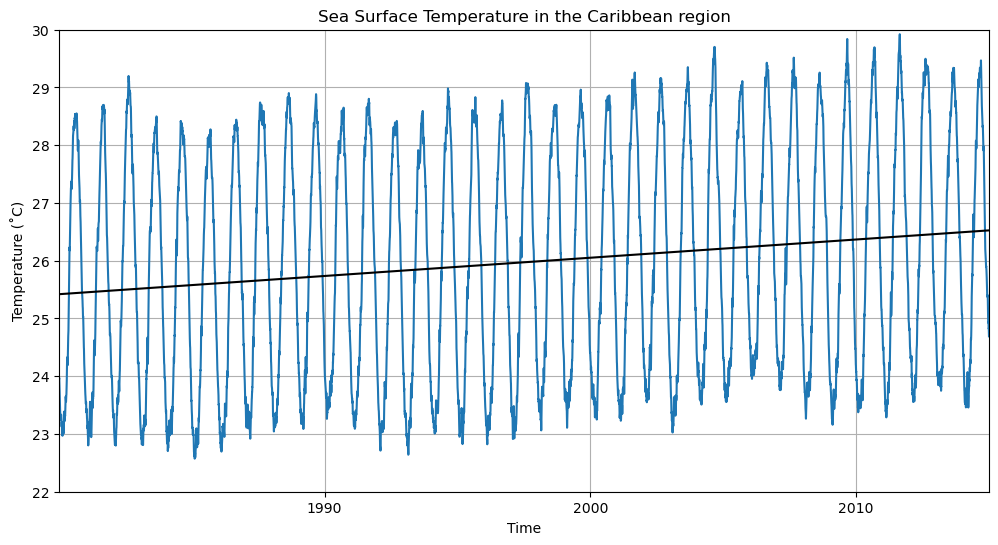

In [19]:
csst.mean(['x', 'y']).plot()
plt.plot(csst.time, trend, color='k')
plt.ylim(22, 30)
plt.xlim(csst.time[0].values, csst.time[-1].values)
plt.xlabel('Time')
plt.ylabel('Temperature (˚C)')
plt.title('Sea Surface Temperature in the Caribbean region')
plt.grid();

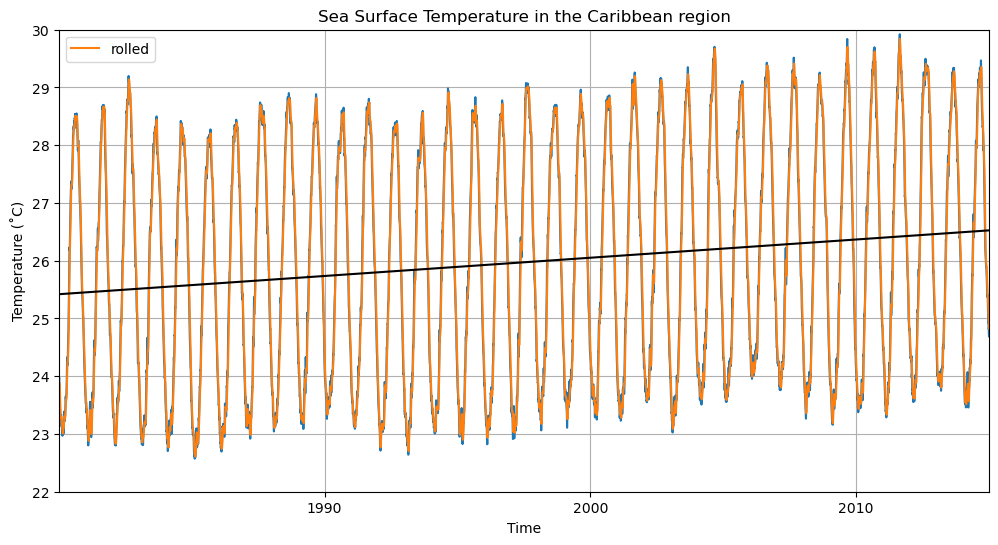

In [45]:
csst.mean(['x', 'y']).plot()
csst.mean(['x', 'y']).rolling(time=10).mean('time').plot(label='rolled')
plt.plot(csst.time, trend, color='k')
plt.ylim(22, 30)
plt.xlim(csst.time[0].values, csst.time[-1].values)
plt.xlabel('Time')
plt.ylabel('Temperature (˚C)')
plt.title('Sea Surface Temperature in the Caribbean region')
plt.grid()
plt.legend();

## Compute climatology and pick fixed SST threshold

In [20]:
clim = csst.groupby('time.dayofyear').mean('time')
anom = csst.groupby('time.dayofyear') - clim

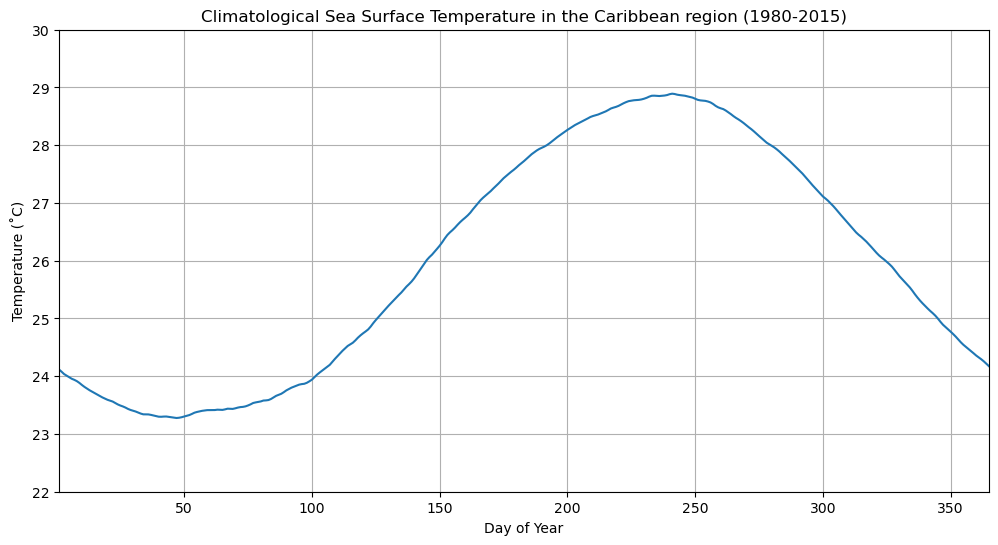

In [21]:
clim.mean(['y', 'x']).plot()
plt.ylim(22, 30)
plt.xlim(clim.dayofyear[0].values, clim.dayofyear[-1].values)
plt.xlabel('Day of Year')
plt.ylabel('Temperature (˚C)')
plt.title('Climatological Sea Surface Temperature in the Caribbean region (1980-2015)')
plt.grid();

## Find the 95th percentile SST

In [22]:
sst95 = csst.quantile(0.95)

In [23]:
sst95

<xarray.DataArray 'tos' ()> Size: 8B
array(29.51353645)
Coordinates:
    quantile  float64 8B 0.95

## Meet the conditions: above 29.5 ˚C and >10 days

In [16]:
mask = csst.chunk({'x':10, 'y':10, 'time':-1})>= 29.5

In [17]:
mask

<xarray.DataArray 'tos' (time: 12775, y: 98, x: 169)> Size: 212MB
dask.array<ge, shape=(12775, 98, 169), dtype=bool, chunksize=(12775, 10, 10), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 66kB dask.array<chunksize=(10, 10), meta=np.ndarray>
    lon      (y, x) float32 66kB dask.array<chunksize=(10, 10), meta=np.ndarray>
  * time     (time) object 102kB 1980-01-01 12:00:00 ... 2014-12-31 12:00:00
  * x        (x) float64 1kB -97.84 -97.58 -97.33 -97.08 ... -55.75 -55.5 -55.25
  * y        (y) float64 784B 8.222 8.469 8.716 8.963 ... 30.46 30.67 30.89

In [18]:
longer_than_10_days = mask.map_blocks(consecutive_days, template=mask) >= 10

In [19]:
longer_than_10_days

<xarray.DataArray 'tos' (time: 12775, y: 98, x: 169)> Size: 212MB
dask.array<ge, shape=(12775, 98, 169), dtype=bool, chunksize=(12775, 10, 10), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 66kB dask.array<chunksize=(10, 10), meta=np.ndarray>
    lon      (y, x) float32 66kB dask.array<chunksize=(10, 10), meta=np.ndarray>
  * time     (time) object 102kB 1980-01-01 12:00:00 ... 2014-12-31 12:00:00
  * x        (x) float64 1kB -97.84 -97.58 -97.33 -97.08 ... -55.75 -55.5 -55.25
  * y        (y) float64 784B 8.222 8.469 8.716 8.963 ... 30.46 30.67 30.89

In [ ]:
time_series = csst.where(longer_than_10_days).mean(["x", "y"])

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 808.71 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [13]:
cfill

<xarray.DataArray 'tos' (time: 12775, y: 98, x: 169)> Size: 846MB
dask.array<where, shape=(12775, 98, 169), dtype=float32, chunksize=(12775, 10, 10), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 66kB dask.array<chunksize=(10, 10), meta=np.ndarray>
    lon      (y, x) float32 66kB dask.array<chunksize=(10, 10), meta=np.ndarray>
  * time     (time) object 102kB 1980-01-01 12:00:00 ... 2014-12-31 12:00:00
  * x        (x) float64 1kB -97.84 -97.58 -97.33 -97.08 ... -55.75 -55.5 -55.25
  * y        (y) float64 784B 8.222 8.469 8.716 8.963 ... 30.46 30.67 30.89
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    long_name:      Sea Surface Temperature
    original_name:  tos
    standard_name:  sea_surface_temperature
    units:          degC

In [14]:
mask

<xarray.DataArray 'tos' (time: 12775, y: 98, x: 169)> Size: 212MB
dask.array<ge, shape=(12775, 98, 169), dtype=bool, chunksize=(12775, 10, 10), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 66kB dask.array<chunksize=(10, 10), meta=np.ndarray>
    lon      (y, x) float32 66kB dask.array<chunksize=(10, 10), meta=np.ndarray>
  * time     (time) object 102kB 1980-01-01 12:00:00 ... 2014-12-31 12:00:00
  * x        (x) float64 1kB -97.84 -97.58 -97.33 -97.08 ... -55.75 -55.5 -55.25
  * y        (y) float64 784B 8.222 8.469 8.716 8.963 ... 30.46 30.67 30.89

In [15]:
def consecutive_days(mask):
    labels = np.logical_not(mask).cumsum('time').where(mask, 0)

    def calculate_group_lengths(g):
        return xr.full_like(g, fill_value=g.count())

    return labels.groupby(labels).apply(calculate_group_lengths).where(mask)

import dask.array as dsa
drhodt_dsa_mapped_random = dsa.map_blocks(
         jmd95numba.drhodt, salt, theta, pref,
         dtype=salt.dtype)
drhodt_dsa_mapped_random

In [ ]:
longer_than_10_days = consecutive_days(cfill >= 29.5) >= 10

In [ ]:
longer_thank

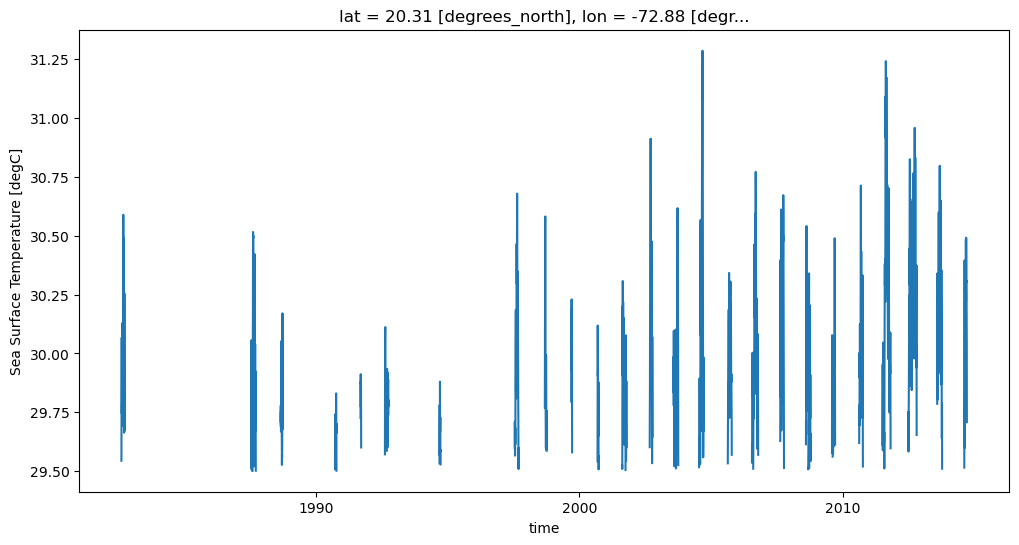

In [ ]:
csst_subset.where(longer_than_10_days).plot()

In [14]:
mask

<xarray.DataArray 'tos' (time: 12775)> Size: 13kB
array([False, False, False, ..., False, False, False])
Coordinates:
    lat      float32 4B 20.31
    lon      float32 4B -72.88
  * time     (time) object 102kB 1980-01-01 12:00:00 ... 2014-12-31 12:00:00
    x        float64 8B -72.44
    y        float64 8B 20.31

In [15]:
consec_vals = (~mask).cumsum('time')

In [16]:
consec_vals

<xarray.DataArray 'tos' (time: 12775)> Size: 102kB
array([    1,     2,     3, ..., 11201, 11202, 11203])
Coordinates:
    lat      float32 4B 20.31
    lon      float32 4B -72.88
  * time     (time) object 102kB 1980-01-01 12:00:00 ... 2014-12-31 12:00:00
    x        float64 8B -72.44
    y        float64 8B 20.31

In [17]:
np.arange(10).cumsum()

array([ 0,  1,  3,  6, 10, 15, 21, 28, 36, 45])

In [18]:
#find the elements in array that meet the conditions of >=29.5 and last for <10days
masked_csst = consec_vals.where(mask)

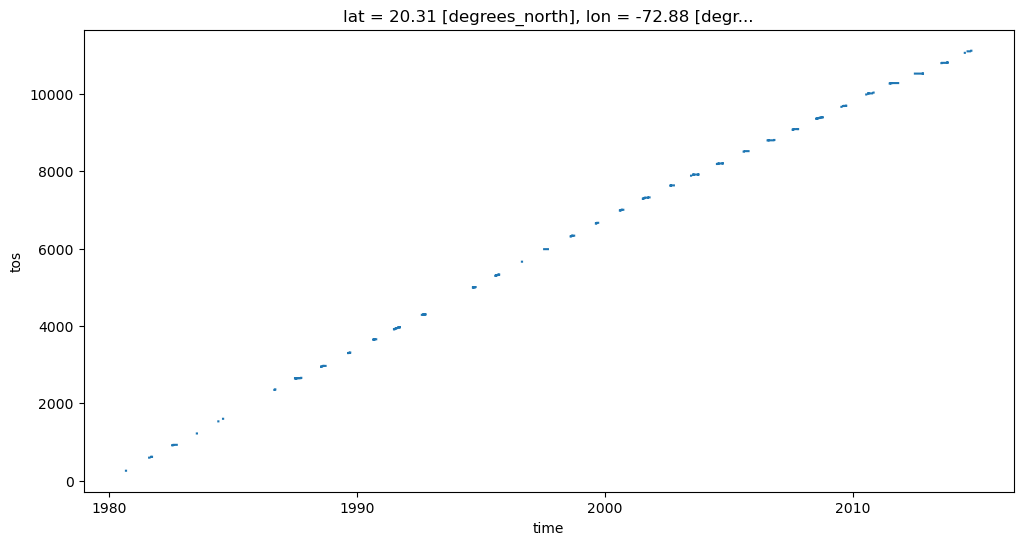

In [20]:
masked_csst.plot()

In [21]:
import flox.xarray

In [22]:
#look at each value in each grid cell at every time step and group together all the elements with the same value/label
group_length = flox.xarray.xarray_reduce(masked_csst, masked_csst, func='count')

In [24]:
group_length

<xarray.DataArray 'tos' (tos: 139)> Size: 1kB
array([  3,   7,   1,   1,   4,   8,   3,   5,  47,   3,   2,   3,   1,
         1,   1,   1,   2,   3,   5,   5,  10,  10,  21,  22,   5,   4,
         1,   1,   2,   9,   1,   5,  29,   3,   5,   6,   4,   1,   7,
         4,   4,  22,   3,   3,   4,   4,   8,  10,   6,  12,   5,  24,
         2,   3,  17,   5,   5,   2,   2,   3,   4,   7,   6,   3,  57,
         1,   1,   2,   2,   5,  26,   1,   1,   2,   2,  14,   4,   6,
         4,  19,   3,   3,   2,   2,  39,  17,   4,   3,  40,   2,   8,
        67,   2,   3,  12,  52,   5,   4,   1,  56,   1,  15,  70,   5,
         1,   3,   6,  53,   3,   1,   2,   8,   3,  11,   1,   4,  16,
        16,   2,  10,  29,   3,   1,   2,   5,  52,   2,   7,  11,  97,
       116,   3,   3,  69,   3,   3,   2,  37,   4])
Coordinates:
    lat      float32 4B 20.31
    lon      float32 4B -72.88
    x        float64 8B -72.44
    y        float64 8B 20.31
  * tos      (tos) float64 1kB 253.0 591.0 595.0 ... 1.11e+04 1.112e+04

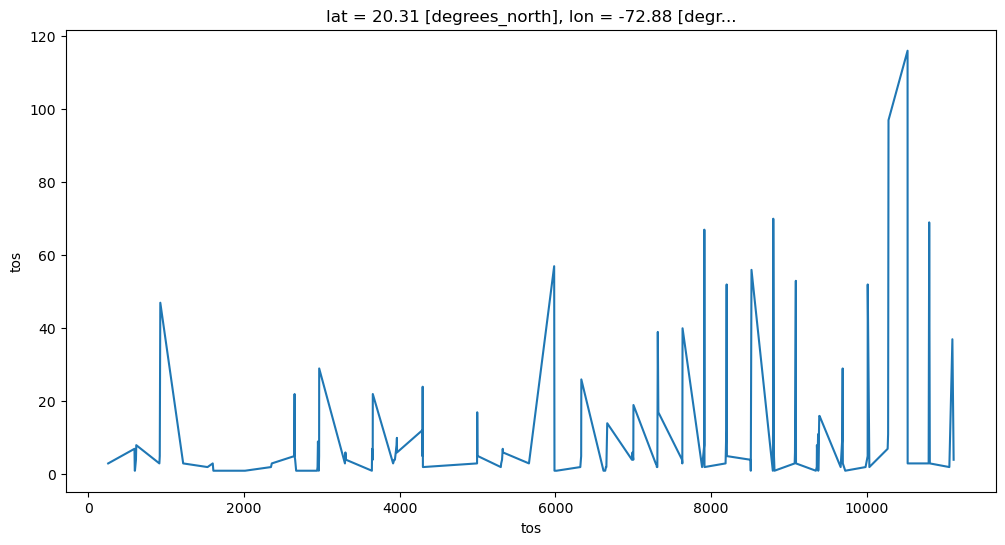

In [23]:
group_length.plot()

In [26]:
masked_csst.where(masked_csst>=10)

<xarray.DataArray 'tos' (time: 12775, y: 98, x: 169)> Size: 2GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    lat      (y, x) float32 66kB 8.222 8.222 8.222 8.222 ... 30.89 30.89 30.89
    lon      (y, x) float32 66kB -97.88 -97.62 -97.38 ... -56.38 -56.12 -55.88
  * time     (time) object 102kB 1980-01-01 12:00:00 ... 2014-12-31 12:00:00
  * x        (x) float64 1kB -97.84 -97.58 -97.33 -97.08 ... -55.75 -55.5 -55.25
  * y        (y) float64 784B 8.222 8.469 8.716 8.963 ... 30.46 30.67 30.89

In [24]:
import flox

In [25]:
flox.

Type:        module
String form: <module 'flox' from '/srv/conda/envs/notebook/lib/python3.11/site-packages/flox/__init__.py'>
File:        /srv/conda/envs/notebook/lib/python3.11/site-packages/flox/__init__.py
Docstring:   Top-level module for flox .

In [23]:
flox.xarray.xarray_reduce(

<xarray.DataArray 'tos' (time: 12775, y: 98, x: 169)> Size: 2GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    lat      (y, x) float32 66kB 8.222 8.222 8.222 8.222 ... 30.89 30.89 30.89
    lon      (y, x) float32 66kB -97.88 -97.62 -97.38 ... -56.38 -56.12 -55.88
  * time     (time) object 102kB 1980-01-01 12:00:00 ... 2014-12-31 12:00:00
  * x        (x) float64 1kB -97.84 -97.58 -97.33 -97.08 ... -55.75 -55.5 -55.25
  * y        (y) float64 784B 8.222 8.469 8.716 8.963 ... 30.46 30.67 30.89

In [62]:
cavg = csst.mean(['y','x'])
mask = cavg >= 29.5
cavg

In [63]:
c

<xarray.DataArray 'tos' (time: 12775)> Size: 51kB
array([23.973158, 23.94524 , 23.955713, ..., 24.764215, 24.714928,
       24.691105], dtype=float32)
Coordinates:
  * time     (time) object 102kB 1980-01-01 12:00:00 ... 2014-12-31 12:00:00

In [61]:
csst#.where(csst>=29.5)

<xarray.DataArray 'tos' (time: 12775, y: 98, x: 169)> Size: 846MB
array([[[      nan,       nan,       nan, ..., 25.8405  , 25.837206,
         25.840914],
        [      nan,       nan,       nan, ..., 25.810337, 25.781202,
         25.783344],
        [      nan,       nan,       nan, ..., 25.795334, 25.74435 ,
         25.726683],
        ...,
        [      nan,       nan,       nan, ..., 19.91767 , 19.753414,
         19.353695],
        [      nan,       nan,       nan, ..., 19.668154, 19.469423,
         19.149704],
        [      nan,       nan,       nan, ..., 19.434666, 19.236498,
         19.017475]],

       [[      nan,       nan,       nan, ..., 25.85912 , 25.85692 ,
         25.86652 ],
        [      nan,       nan,       nan, ..., 25.819614, 25.79908 ,
         25.821692],
        [      nan,       nan,       nan, ..., 25.78365 , 25.73449 ,
         25.756374],
...
        [      nan,       nan,       nan, ..., 21.318853, 21.47445 ,
         21.460293],
        [      nan,       nan,       nan, ..., 21.11503 , 21.28229 ,
         21.252943],
        [      nan,       nan,       nan, ..., 20.638948, 20.861607,
         20.986332]],

       [[      nan,       nan,       nan, ..., 26.682354, 26.65766 ,
         26.601227],
        [      nan,       nan,       nan, ..., 26.675678, 26.650387,
         26.605356],
        [      nan,       nan,       nan, ..., 26.662418, 26.64014 ,
         26.600674],
        ...,
        [      nan,       nan,       nan, ..., 21.230621, 21.442247,
         21.452328],
        [      nan,       nan,       nan, ..., 21.071938, 21.265345,
         21.223864],
        [      nan,       nan,       nan, ..., 20.654604, 20.853203,
         20.919558]]], dtype=float32)
Coordinates:
    lat      (y, x) float32 66kB 8.222 8.222 8.222 8.222 ... 30.89 30.89 30.89
    lon      (y, x) float32 66kB -97.88 -97.62 -97.38 ... -56.38 -56.12 -55.88
  * time     (time) object 102kB 1980-01-01 12:00:00 ... 2014-12-31 12:00:00
  * x        (x) float64 1kB -97.84 -97.58 -97.33 -97.08 ... -55.75 -55.5 -55.25
  * y        (y) float64 784B 8.222 8.469 8.716 8.963 ... 30.46 30.67 30.89
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    long_name:      Sea Surface Temperature
    original_name:  tos
    standard_name:  sea_surface_temperature
    units:          degC

In [24]:
xtremeT = csst.where(csst>=29.5)

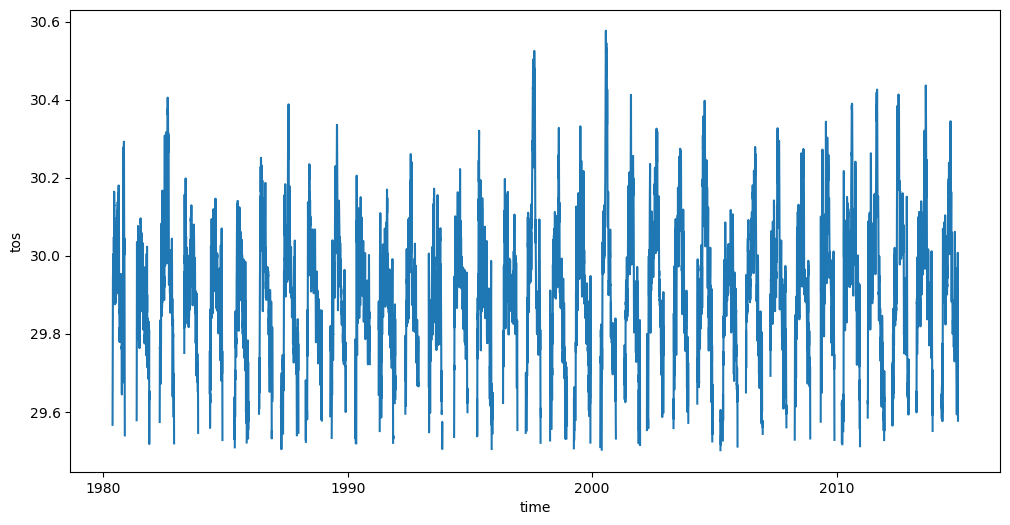

In [26]:
xtremeT.mean(['y', 'x']).plot()

In [70]:
csst.rolling(time=10).mean('time')

<xarray.DataArray 'tos' (time: 12775, y: 98, x: 169)> Size: 846MB
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ..., 21.453669, 21.625687,
         21.639153],
        [      nan,       nan,       nan, ..., 21.177094, 21.37635 ,
         21.388908],
        [      nan,       nan,       nan, ..., 20.708212, 20.989922,
         21.119654]],

       [[      nan,       nan,       nan, ..., 26.74406 , 26.735626,
         26.717539],
        [      nan,       nan,       nan, ..., 26.737295, 26.725538,
         26.710045],
        [      nan,       nan,       nan, ..., 26.730677, 26.718039,
         26.702015],
        ...,
        [      nan,       nan,       nan, ..., 21.406494, 21.588163,
         21.604095],
        [      nan,       nan,       nan, ..., 21.147705, 21.344933,
         21.348736],
        [      nan,       nan,       nan, ..., 20.690414, 20.951838,
         21.077408]]], dtype=float32)
Coordinates:
    lat      (y, x) float32 66kB 8.222 8.222 8.222 8.222 ... 30.89 30.89 30.89
    lon      (y, x) float32 66kB -97.88 -97.62 -97.38 ... -56.38 -56.12 -55.88
  * time     (time) object 102kB 1980-01-01 12:00:00 ... 2014-12-31 12:00:00
  * x        (x) float64 1kB -97.84 -97.58 -97.33 -97.08 ... -55.75 -55.5 -55.25
  * y        (y) float64 784B 8.222 8.469 8.716 8.963 ... 30.46 30.67 30.89
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    long_name:      Sea Surface Temperature
    original_name:  tos
    standard_name:  sea_surface_temperature
    units:          degC

In [35]:
#rolling mean of 10days
roll10 = csst.mean(['y', 'x']).rolling(time=10).mean('time')
xtreme = xr.full_like(roll10, 'none', dtype='U4')

In [36]:
xtreme[roll10 >= 29.5] = 'xtreme'

In [37]:
xtreme

<xarray.DataArray 'tos' (time: 12775)> Size: 204kB
array(['none', 'none', 'none', ..., 'none', 'none', 'none'], dtype='<U4')
Coordinates:
  * time     (time) object 102kB 1980-01-01 12:00:00 ... 2014-12-31 12:00:00

In [38]:
xcomposite = csst.groupby(xtreme).mean('time')

In [43]:
xcomposite.mean(['y','x'])#.plot()

<xarray.DataArray 'tos' (tos: 2)> Size: 8B
array([25.951145, 29.604122], dtype=float32)
Coordinates:
  * tos      (tos) object 16B 'none' 'xtre'

In [ ]:
sst_anom_nino34_mean = sst_anom_nino34.mean(dim=('lon', 'lat'))
oni = sst_anom_nino34_mean.rolling(time=3).mean(dim='time')

# create a categorical  dataarray
nino34 = xr.full_like(oni, 'none', dtype='U4')
nino34[oni >= 0.5] = 'nino'
nino34[oni <= -0.5] = 'nina'
nino34

sst_nino_composite = sst_anom.groupby(nino34.rename('nino34')).mean(dim='time')

nino_ds = xr.Dataset({'nino34': nino34, 'oni': oni}).drop('month')
nino_ds.to_netcdf('nino34_index.nc')

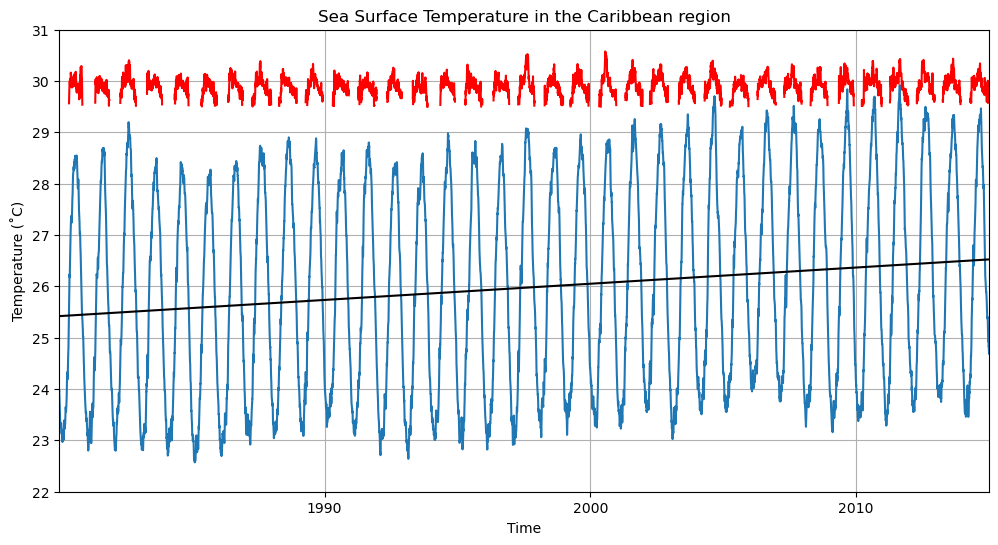

In [28]:
csst.mean(['x', 'y']).plot()
plt.plot(csst.time, trend, color='k')
xtremeT.mean(['y', 'x']).plot(color='r')
plt.ylim(22, 31)
plt.xlim(csst.time[0].values, csst.time[-1].values)
plt.xlabel('Time')
plt.ylabel('Temperature (˚C)')
plt.title('Sea Surface Temperature in the Caribbean region')
plt.grid();

## El Niño 3.4 idnex

If you're comfortable, and as we briefly used for our embedded logo up top, you can embed raw html into Jupyter Markdown cells (edit to see):

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Your relevant information here!
</div>

Feel free to copy this around and edit or play around with yourself. Some other `admonitions` you can put in:

<div class="admonition alert alert-success">
    <p class="admonition-title" style="font-weight:bold">Success</p>
    We got this done after all!
</div>

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    Be careful!
</div>

<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">Danger</p>
    Scary stuff be here.
</div>

We also suggest checking out Jupyter Book's [brief demonstration](https://jupyterbook.org/content/metadata.html#jupyter-cell-tags) on adding cell tags to your cells in Jupyter Notebook, Lab, or manually. Using these cell tags can allow you to [customize](https://jupyterbook.org/interactive/hiding.html) how your code content is displayed and even [demonstrate errors](https://jupyterbook.org/content/execute.html#dealing-with-code-that-raises-errors) without altogether crashing our loyal army of machines!

---

## Summary
Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!